In [34]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import requests
from madxtools.plot_tool import *
import os
import glob
def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [8]:
# Beam characteristics
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

In [9]:
# Initial conditions
initial_conditions = {'measurement': 
            {'betx0': 154.0835045206266,
             'bety0': 5.222566527078791,
             'alfx0': -36.90472944993891,
             'alfy0': 0.2523074897915478,
             'Dx0': 0.13,
             'Dy0': 0.0,
             'Dpx0': 0.02,
             'Dpy0': 0.0,
             'exn': 7.639770207283603e-06,
             'eyn': 3.534081877201574e-06,
             'sige': 0.000679081344780741},
            'stray_field': 
            {'betx0': 155.11241116764313,
             'bety0': 2.682104074061644,
             'alfx0': -36.57756982474437,
             'alfy0': 1.8286185977404674,
             'Dx0': 0.13,
             'Dy0': 0.0,
             'Dpx0': 0.02,
             'Dpy0': 0.0,
             'exn': 4.549658248792639e-06,
             'eyn': 9.777271920638397e-07,
             'sige': 0.000679081344780741}
            }

In [19]:
initial_cond = "measurement"

def create_madx(initial_cond):

    madx = Madx()
    madx.option(verbose=False, debug=False, echo=False, warn=False, twiss_print=False)

    madx.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/2021/ps_extraction/f61d/f61d.dbx").text)
    madx.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/2021/ps_extraction/f61d/f61d.ele").text)
    madx.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/2021/ps_extraction/f61d/f61d.seq").text)
    madx.input(requests.get("https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/2021/ps_extraction/f61d/f61d_proton.str").text)

    ex = initial_conditions[initial_cond]['exn']/(beta*gamma)
    ey = initial_conditions[initial_cond]['eyn']/(beta*gamma)

    madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

    madx.input('SEQEDIT, SEQUENCE=f61d;')
    madx.input('FLATTEN;')
    madx.input('REMOVE, ELEMENT=ARBMATRIX;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')

    madx.input("kQFN1 = "+str(0.4797)+";")
    madx.input("kQDN2 = "+str(-0.173)+";")
    madx.input("kQFN3 = "+str(0.1986)+";")

    madx.use(sequence="f61d")
    madx.twiss(betx=initial_conditions[initial_cond]['betx0'], bety=initial_conditions[initial_cond]['bety0'], alfx=initial_conditions[initial_cond]['alfx0'], alfy=initial_conditions[initial_cond]['alfy0'], Dx=initial_conditions[initial_cond]['Dx0'], Dy=initial_conditions[initial_cond]['Dy0'], Dpx=initial_conditions[initial_cond]['Dpx0'], Dpy=initial_conditions[initial_cond]['Dpy0']).dframe()

    return madx

madx_list = []

for initial_cond in ['measurement', 'stray_field']:
    madx_list.append(create_madx(initial_cond))


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.07.31 15:32:53      +
  ++++++++++++++++++++++++++++++++++++++++++++

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.07.31 15:32:53      +
  ++++++++++++++++++++++++++++++++++++++++++++


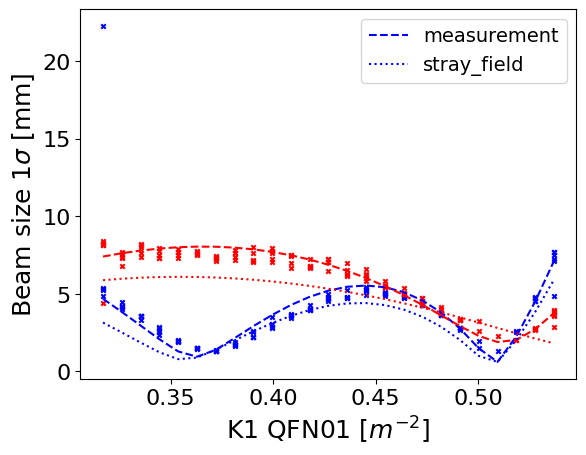

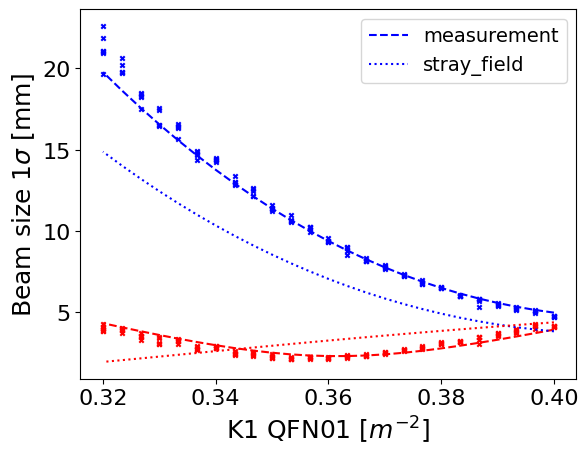

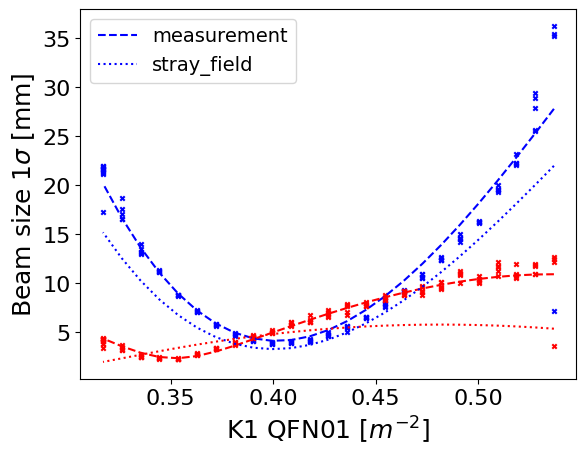

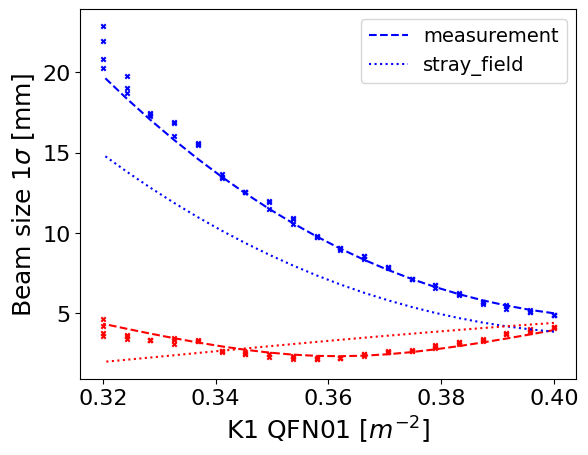

In [44]:
# List all pickle files in the 'large_df' directory
pickle_files = glob.glob('large_df/*.pickle')

# Filter out files containing the string "ions"
pickle_files = [file for file in pickle_files if 'ions' not in file]

for pickle_file in pickle_files:

    fig, ax = plt.subplots()

    df = pd.read_pickle(pickle_file)

    # Measurements
    Acqu = 3
    ax.scatter(df.loc[df.Acqu==Acqu].k_qfn01, df.loc[df.Acqu==Acqu].poptH3_cal, s=10, marker="x", c="b")
    ax.scatter(df.loc[df.Acqu==Acqu].k_qfn01, df.loc[df.Acqu==Acqu].poptV3_cal, s=10, marker="x", c="r")

    kQFN01_list = df.loc[df.Acqu==Acqu].k_qfn01

    loc = "f61.btv010"

    for initial_cond in ['measurement','stray_field']:
        if initial_cond == 'measurement':
            madx_inst = 0
            linestyle = "--"
        if initial_cond == 'stray_field':
            madx_inst = 1
            linestyle = ":"

        sigma_H_list = []
        sigma_V_list = []

        for i in range(len(kQFN01_list)):

            kQFN01 = df.loc[df.Acqu==Acqu].iloc[i].k_qfn01
            kQDN02 = df.loc[df.Acqu==Acqu].iloc[i].k_qdn02
            kQFN03 = df.loc[df.Acqu==Acqu].iloc[i].k_qfn03

            madx_list[madx_inst].input(f"kQFN1 = {kQFN01}")
            madx_list[madx_inst].input(f"kQDN2 = {kQDN02}")
            madx_list[madx_inst].input(f"kQFN3 = {kQFN03}")
            twiss_f61d = madx_list[madx_inst].twiss(betx=initial_conditions[initial_cond]['betx0'], bety=initial_conditions[initial_cond]['bety0'], alfx=initial_conditions[initial_cond]['alfx0'], alfy=initial_conditions[initial_cond]['alfy0'], Dx=initial_conditions[initial_cond]['Dx0'], Dy=initial_conditions[initial_cond]['Dy0'], Dpx=initial_conditions[initial_cond]['Dpx0'], Dpy=initial_conditions[initial_cond]['Dpy0']).dframe()

            sigma_H_meas = beam_size(twiss_f61d['betx'][loc], twiss_f61d['dx'][loc], initial_conditions[initial_cond]['exn']/(beta*gamma), sige, 1)*1000
            sigma_V_meas = beam_size(twiss_f61d['bety'][loc], twiss_f61d['dy'][loc], initial_conditions[initial_cond]['eyn']/(beta*gamma), sige, 1)*1000

            sigma_H_list.append(sigma_H_meas)
            sigma_V_list.append(sigma_V_meas)

        ax.plot(kQFN01_list, sigma_H_list, c="b", linestyle = linestyle, label=initial_cond)
        ax.plot(kQFN01_list, sigma_V_list, c="r", linestyle = linestyle)

    ax.legend()

    ax.set_xlabel("K1 QFN01 [$m^{-2}$]")
    ax.set_ylabel("Beam size $1\sigma$ [mm]")

    # Get the base filename without the directory
    base_filename = os.path.basename(pickle_file)

    # Remove the '.pickle' extension
    base_filename = base_filename[:-7]

    # Remove the leading part of the filename up to the date
    date_time = base_filename.split("_")[-1]  # split the filename by underscore and take the last part
        

    plt.savefig(f"fig/initial_conditions_comparison_{date_time}.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')